# AI Model Distillation for Financial Data Developer Example

[![Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://brev.nvidia.com/launchable/deploy?launchableID=env-2wggjBvDlVp4pLQD8ytZySh5m8W)

In this notebook, you will learn how to use the AI Model Distillation for Financial Data developer example to distill and customize models to meet the performance of larger models for specific tasks.

### Architecture Diagram

![AI Model Distillation for Financial Data](~/ai-model-distillation-for-financial-data/notebooks/img/findistil_diagram.png)

## Overview

This notebook is divided into two main parts:

**Part 1: Label Generation with Teacher Model**
- Generate high-quality labels for financial news headlines using a large language model (teacher model)
- The teacher model (Llama 3.3 70B Instruct or Llama 3.3 Nemotron Super 49B) classifies headlines into 13 event categories
- Validate the teacher model's performance against manually labeled data

**Part 2: Data Flywheel Runs**
- Use the labeled data to drive the flywheel process
- Fine-tune smaller LLMs (`meta/llama-3.2-1b-instruct`, `meta/llama-3.2-3b-instruct`, `meta/llama-3.1-8b-instruct`)
- Iteratively improve model performance to match the accuracy of the teacher model
- Deploy and test the customized models

---

## Navigation

### Part 1: Label Generation with Teacher Model

1.1. [Load Dataset](#part1-section1)  
1.2. [Teacher Model Label Generation (Optional - ~1 hour)](#part1-section2)
   - 1.2.1 Setup and Deploy Teacher Model
   - 1.2.2 Define Classification Prompt
   - 1.2.3 Generate and Clean Labels
   - 1.2.4 Save Results and Cleanup

1.3. [Validation on Manually Labeled Data](#part1-section3)  
1.4. [Visualize Existing Labels](#part1-section4)

### Part 2: Data Flywheel Runs

2.0. [Data Flywheel Setup](#part2-section0)  
2.1. [Load Sample Data](#part2-section1)  
2.2. [Create a Flywheel Job](#part2-section2)  
2.3. [Monitor Job Status](#part2-section3)  
2.4. [Show Continuous Improvement](#part2-section4)
   - 2.4.1 Run with 10K samples
   - 2.4.2 Run with 25K samples

2.5. [Deploy Customized Model and Run Inference](#part2-section5)  
2.6. [Expose the Customized Model for External Access](#part2-section6)

---

> **Note:** The `deploy-nmp.sh` script automates the deployment of NeMo Microservices. For manual setup or advanced configuration, please consult the [NeMo Microservices documentation](https://docs.nvidia.com/nemo/microservices/latest/get-started/platform-prereq.html#beginner-tutorial-prerequisites).


The following cells will guide you through the initial setup process, including cloning the repository, installing dependencies, and configuring your environment to run this notebook successfully.


In [ ]:
%%bash
git clone https://github.com/NVIDIA-AI-Blueprints/ai-model-distillation-for-financial-data.git
cd ai-model-distillation-for-financial-data
sudo apt-get update && sudo apt-get install -y git-lfs
git lfs install
git-lfs pull

In [1]:
from pathlib import Path
import os
notebook_dir = Path.cwd()
notebook_dir = notebook_dir.parent
project_root = notebook_dir 
local_bin = os.path.expanduser("~/.local/bin")
os.environ["PATH"] = f"{local_bin}:{os.environ['PATH']}"
print(f"Updated PATH to include: {local_bin}")

import sys

data_dir = project_root / "data"
sys.path.insert(0, str(project_root))
os.chdir(project_root)
print(f"Working directory changed to: {Path.cwd()}")

Updated PATH to include: /home/shadeform/.local/bin
Working directory changed to: /home/shadeform/ai-model-distillation-for-financial-data


In [2]:
!uv pip install -r notebooks/requirements.txt

Using Python 3.12.12 environment at: /home/shadeform/.venv
Resolved 59 packages in 385ms                                        
⠙ Preparing packages... (0/42)                                                  
⠙ Preparing packages... (0/42)------------------     0 B/301.17 KiB          
⠙ Preparing packages... (0/42)------------------     0 B/301.17 KiB          
click                ------------------------------     0 B/105.74 KiB
⠙ Preparing packages... (0/42)------------------     0 B/301.17 KiB          
click                ------------------------------     0 B/105.74 KiB
⠙ Preparing packages... (0/42)------------------     0 B/301.17 KiB          
click                ------------------------------     0 B/105.74 KiB
⠙ Preparing packages... (0/42)------------------     0 B/301.17 KiB          
typer-slim           ------------------------------     0 B/45.98 KiB
click                ------------------------------     0 B/105.74 KiB
⠙ Preparing packages... (0/42)----------------

Set NGC API key following the instructions at [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html#generating-api-key).

**When creating the key, make sure Public API Enpoints are included in the services.**


In [ ]:
import os
from getpass import getpass
os.environ['NGC_API_KEY'] = getpass("Enter your NGC API Key")

In [ ]:
%%bash
set -e

log() {
  echo -e "\033[1;32m[INFO]\033[0m $1"
}

echo "$NGC_API_KEY" | docker login nvcr.io -u '$oauthtoken' --password-stdin
chmod +x scripts/deploy-nmp.sh
./scripts/deploy-nmp.sh --progress

Login Succeeded
[INFO] Starting NeMo Microservices deployment...
[INFO] Detailed logs will be written to: /tmp/nemo-deploy.log

[INFO] Step 1/8: Checking prerequisites [██████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 12%
[INFO] Step 2/8: Downloading Helm chart [████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 25%
[INFO] Step 3/8: Starting Minikube [██████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] 37%


# Part 1: Label Generation with Teacher Model

This part demonstrates how to use a large language model (teacher model) to generate high-quality labels for financial news headlines. The teacher model (Llama 3.3 70B Instruct or Llama 3.3 Nemotron Super 49B) classifies headlines into 13 event categories based on financial news classification criteria.

## Workflow Overview

1. **Load Dataset** (Section 1.1): Download raw financial news headlines from HuggingFace
2. **Generate Labels** (Section 1.2): Deploy teacher model and classify all headlines (~1-1.5 hours)
   - 1.2.1 Setup and Deploy Teacher Model (~15-20 mins)
   - 1.2.2 Define Classification Prompt
   - 1.2.3 Generate and Clean Labels (~35-45 mins)
   - 1.2.4 Save Results and Cleanup
3. **Validate** (Section 1.3, Optional): Test teacher model performance on manually labeled data
4. **Visualize** (Section 1.4, Optional): Explore label distribution

**Estimated Total Runtime:** ~1-1.5 hours (depending on GPU hardware and dataset size)

> **Note:** You must complete sections 1.1 and 1.2 before proceeding to Part 2. The labeled data generated here will be used for the Data Flywheel runs.


<a id="part1-section1"></a>
## 1.1. Load Dataset

Load the raw financial news dataset. This dataset will be used for label generation or analysis.


In [3]:
import requests
import time
import datasets
import pandas as pd
from src.scripts.nim_helpers import create_model_deployment, delete_model_deployment, delete_model_from_store, list_model_deployments, list_all_deployments

/home/shadeform/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Download dataset from huggingface
For this exercise we use news sentiment dataset. 
There are several datasets on huggingface and Kaggle which users can leverage for this task. 
 - [Stock news sentiment](https://huggingface.co/datasets/ic-fspml/stock_news_sentiment) (Huggingface)
 - [US financial news](https://www.kaggle.com/datasets/jeet2016/us-financial-news-articles) (Kaggle)

**“User is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.”**

In [16]:
# Download and save dataset directly
# before final release we will swap the below with <<REPLACE WITH DATASET FORM HUGGINGFACE>>
dataset_name = "ic-fspml/stock_news_sentiment"
data = datasets.load_dataset(dataset_name)
save_path = project_root / "data" / "news_data_raw" / "stock_news_sentiment"
data.save_to_disk(save_path)

# Rename column 'article_headline' to 'headline'
data = data.rename_column('article_headline', 'headline')
data.save_to_disk(save_path)

Saving the dataset (1/1 shards): 100%|██████████| 30150/30150 [00:00<00:00, 1632498.94 examples/s]


In [ ]:
# for testing this notebook lets use the cleaned dataset we have
import datasets
dataset_path = project_root / "data" / "news_data_raw" / "teacher_model_labelled"
data = datasets.load_from_disk(str(dataset_path))

<a id="part1-section2"></a>
## 1.2. Teacher Model Label Generation (~1.5 hours to run)

**In this section, we will go through the following steps:**
1. Deploy Llama 3.3 70B Instruct or Llama 3.3 Nemotron Super 49B model (~15-20 mins) - **Required for Section 1.3**
2. Define classification prompt with 13 event categories
3. Generate labels for all headlines (~35-45 mins)
4. Clean and standardize the labels
5. Save results to CSV
6. Clean up deployment resources

**Estimated total time: ~1 hour**


### 1.2.1 Setup and Deploy Teacher Model

Set up paths, import libraries, and deploy the teacher model (Llama 3.3 70B Instruct or Llama 3.3 Nemotron Super 49B).



In [5]:
# select the model you want to deploy
TEACHER_MODEL_NAME = "llama-3.3-nemotron-super-49b-v1"
TEACHER_MODEL_NAMESPACE = "nvidia"

# TEACHER_MODEL_NAME = "llama-3.3-70b-instruct"
# TEACHER_MODEL_NAMESPACE = "meta"


In [6]:
list_model_deployments("http://nemo.test")

Found 4 deployment(s):



{'data': None,
 'filter': {},
 'object': 'list',
 'pagination': {'current_page_size': 0,
  'page': 1,
  'page_size': 10,
  'total_pages': 1,
  'total_results': 0}}

In [8]:
if TEACHER_MODEL_NAME == "llama-3.3-nemotron-super-49b-v1":
    #use the following code to deploy the model llama nemotron 
    payload = {
        "name": "llama-3.3-nemotron-super-49b-v1",
        "namespace": "nvidia",
        "config": {
            "model": "nvidia/llama-3.3-nemotron-super-49b-v1",
            "nim_deployment": {
                "image_name": "nvcr.io/nim/nvidia/llama-3.3-nemotron-super-49b-v1",
                "image_tag": "latest",
                "pvc_size": "256Gi",  # Example size - adjust as needed
                "gpu": 2,
                "disable_lora_support": True,
                "additional_envs": {
                    "NIM_GUIDED_DECODING_BACKEND": "outlines",
                }
            }
        }
    }
    create_model_deployment(ENTITY_STORE_URL="http://nemo.test",
                            name="llama-3.3-nemotron-super-49b-v1", 
                            namespace="nvidia", 
                            payload=payload)


# create model deployment
# nvcr.io/nim/nvidia/llama-3.3-nemotron-super-49b-v1.5:latest
if TEACHER_MODEL_NAME == "llama-3.3-70b-instruct":
    payload = {
        "name": "llama-3.3-70b-instruct",
        "namespace": "meta",
    "config": {
        "model": "meta/llama-3.3-70b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.3-70b-instruct",
            "image_tag": "1.8.5",
            "pvc_size": "25Gi",
            "gpu": 2, 
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines",
            }
        }
    }
}

    create_model_deployment(ENTITY_STORE_URL="http://nemo.test",
                        name="llama-3.3-70b-instruct", 
                        namespace="meta", 
                        payload=payload)

Error: 500 {"message":"model deployment already exists","requestId":"6ba521e9f33bd81bf0c336ae27b65737"}



In [9]:
list_all_deployments("http://nemo.test")

Found 1 deployment(s):
  - nvidia/llama-3.3-nemotron-super-49b-v1


Test the deployment with a simple prompt to verify the model is ready:

In [ ]:
url = "http://nim.test/v1/chat/completions"
model = f"{TEACHER_MODEL_NAMESPACE}/{TEACHER_MODEL_NAME}"

payload = {
    "model": model,
    "messages": [
        {"role": "user", "content": "What is the capital of France?"}
    ],
    "max_tokens": 200,
    "temperature": 0.7
}
while True:
    try:
        response = requests.post(url, json=payload)
        print(response.json()['choices'][0]['message']['content'])
        break
    except Exception as e:
        print("Waiting for NIM to be ready...")
        time.sleep(100)

Waiting for NIM to be ready...


Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
Waiting for NIM to be ready...
The capital of France is **Paris**.


List the available models to confirm deployment:

In [ ]:
response = requests.get("http://nim.test/v1/models")
if response.status_code == 200:
    models = [m['id'] for m in response.json()['data']]
    print(f"Models: {models}") 

Models: ['nvidia/llama-3.3-nemotron-super-49b-v1']


In [17]:
import asyncio
import aiohttp

async def classify_headline(session, headline):
    """Get classification for a single headline."""
    # Use the PROMPT from the notebook, formatted with the headline
    prompt = PROMPT.format(headline=headline)
    payload = {
        "model": f"{TEACHER_MODEL_NAMESPACE}/{TEACHER_MODEL_NAME}",
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 100,
        "temperature": 0.4
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content']

async def process_dataset(dataset, headline_column='headline', num_samples=None, concurrent=10):
    """Process headlines and return DataFrame with headline and predicted_label."""
    # Access headlines directly from the dataset column
    if num_samples is None:
        headlines = dataset['train'][headline_column]
    else:
        headlines = dataset['train'][headline_column][:num_samples]
    
    semaphore = asyncio.Semaphore(concurrent)
    
    async def classify_with_limit(session, headline):
        async with semaphore:
            label = await classify_headline(session, headline)
            return {"headline": headline, "predicted_label": label}
    
    async with aiohttp.ClientSession() as session:
        tasks = [classify_with_limit(session, h) for h in headlines]
        results = await asyncio.gather(*tasks)
    
    return pd.DataFrame(results)


### 1.2.2 Define Classification Prompt

Define the comprehensive prompt with all 13 event categories and examples.

*Reference tutorial for understanding prompt tuning: [dspy classification](https://dspy.ai/tutorials/classification_finetuning/)*


In [18]:
PROMPT = """
You are a helpful AI assistant that analyses financial news headlines and identifies what event type is described.
You will classify event types into one of the following categories (in square brackets)

- [Analyst Rating]: An entity such as a bank, asset manager, etc. gives a classification/rating/downgrade/upgrade/opinion to an asset.
                    If there is no specified analyst and company given, it's not Analyst Rating and should be classified as OTHER.
- [Price Targets]: A mention of a price target (PT) is given by an entity such as bank, asset manager, etc.
                   This takes priority over any other class, so if a price target is present use this class!
- [Earnings]: Reports of quarterly, monthly, etc. concrete values of revenue, ESP, etc. Percentage fluctations.
              Expected values are not Earnings and should be Guidance instead!
- [Labour Issues]: Mentions of layoffs, union action, strikes, rising cost of labour, bonuses for execs, etc. Important personal change, e.g. CEO, CFO, VPs, etc.
- [Mergers and Acquisitions]: Whenever merging or acquisition of entities, not just companies, is mentioned.
                              Things like partnerships do not belong to this class! Takes priority over other classes.
- [Dividends]: Mentions of dividend performance, dividend per share, decisions not to issue dividends, etc.
- [Regulatory]: Mentions corporate position focused on environmental affairs, government regulation, international treaties, geopolitics, debt repayment, licenses, patents, etc.
                Any executive decisions taken by the government are Regulatory. Takes priority over other classes.
- [Stock price movement]: Includes pricing of public offerings, daily, monthly and yearly movements, highs and lows, options trade and alerts, etc.
                          Only relevant when a specific entity/industry or set of entities/industries mentioned.
                          Quantities such as sales, are not stock price movements. Stock splits do not count as stock movements.
                          Takes priority over Earnings, Stock Price Movement, Credit Ratings
- [Credit Ratings]: Adjustments of company's borrowing capacity, changes in debt values, changes in ratings, etc.
- [Products-Services]: Mentions of a company's particular product, forward-looking product directions, disruption, government and private contracts, etc.
                       Any sort of delay regarding a product roll-out, etc.
- [Product Approval]: Mentions FDA approvals, environmental approvals, acceptance for review. Any time an entity approves the rollout of a corporations product.
- [Guidance]: Forward looking statements issued by the company's themselves regarding Revenue, EPS, potential sales going up/down, number of contracts, etc.
              Similar talk to earnings but about projections rather than realised.
              
If the headline doesn't match any of the classes, classify it as OTHER.
ATTENTION:
  - Only assign a category if the headline meets all the criteria listed for that category. Otherwise use OTHER
  - Encourage precise matching rather than assigning categories based on partial or superficial similarities
  - OTHER is the default category when in doubt
  - If there are no specific companies mentioned, use OTHER

A few examples:

1. Cornerstone OnDemand Higher as Barclays Upgraded to Overweight -> [Analyst Rating]
2. HC Wainwright & Co. Maintains Buy on Balchem, Lowers Price Target to $104 -> [Price Targets]
3. Sina Reports Q4 Adj. EPS $0.24 vs $0.18 Est., Sales $211.1M vs $207.6M Est.; Sees FY15 Sales $800M-$900M vs $884.6M Est. -> [Earnings]
4. Delta To Buy Out Employees, Offer Early Retirement (DAL) -> [Labour Issues]
5. Constant Contact Announces Deal to Be Purchased by Endurance Int'l at $32/Share -> [Mergers and Acquisitions]
6. Ameriprise Financial Announces 12% Qtr. Dividend Increase to $0.58/Share -> [Dividends]
7. Ultratech Achieves ISO 9001 and 14001 Certification for Singapore Operations and Recertification for U.S. Facility  -> [Regulatory]
8. Mid-Afternoon Market Update: Dow Up Over 200 Points; Lakeland Industries Shares Spike Higher -> [Stock price movement]
9. Moody's Affirms Ratings on Nokia; Outlook Revised from Negative to Developing -> [Credit Ratings]
10. NOVAVAX Awarded HHS-BARDA Contract Valued at up to $179 Million  -> [Products-Services]
11. Sanofi's Genzyme Announces Lemtrada Resubmission Accepted for Review by FDA  -> [Product Approval]
12. Dot Hill Systems Announces Re-alignment of Software Development Initiatives; Sees Q4 EPS of $(0.02)-(0.03) vs $0.03-(0.03) Prior  -> [Guidance]
13. Kopin Chairman Fan Buys 116,400 Shares @$2.83/Share -Form 4 -> [OTHER]

Given the following headline:

### START HEADLINE ###

{headline}

### END HEADLINE ###

What event type best classifies it? Answer only with your predicted class and give it inside double square brackets, like [[class]]
"""

### 1.2.3 Generate and Clean Labels

Process the dataset through the teacher model and standardize the outputs. Note: Replace the `headline_column` parameter with the appropriate column name from your dataset if different.

In [ ]:
# For this setup we will use 50000 samples
# replace the headline column with the appropriate column name from the dataset
df = await process_dataset(data, headline_column='headline', concurrent=200)
df['predicted_label'] = df['predicted_label'].apply(lambda x: x.strip('[]'))
df

,headline,predicted_label
0,HHS Strong Arms Insurers in Nine States,Regulatory
1,Non-Streak Dividend ETFs Impress,Dividends
2,Oncolytics Biotech Inc. Reports 2010 EPS of $(...,Earnings
3,NPS Pharma Says Gattex Meeting October 16th,Products-Services
4,InterOil Announces Supreme Court of Yukon Find...,Regulatory
...,...,...
200993,"T2 Shares Open at $15.95/Share, IPO Priced at $11",Stock price movement
200994,UPDATE: Lexmark Board Formed Committee of Inde...,OTHER
200995,35 Stocks Moving In Monday's Mid-Day Session,Stock price movement
200996,Vipshop Holdings Q2 Adj. EPS $0.13 Misses $0.1...,Earnings


In [20]:
df.groupby('predicted_label').size()

predicted_label
Analyst Rating              17075
Credit Ratings                721
Dividends                    2772
Earnings                    18247
Guidance                     8579
Labour Issues                3539
Mergers and Acquisitions     8433
OTHER                       51866
Price Targets               18029
Product Approval             1556
Products-Services           11310
Regulatory                   8262
Stock price movement        50609
dtype: int64

### Label Standardization

The teacher model may generate labels with slight variations in formatting (e.g., extra brackets, inconsistent capitalization, or synonyms). To ensure consistency, we use a cleanup process that:

1. **Defines a canonical taxonomy** of exactly 13 valid event categories
2. **Uses the LLM to standardize** any non-conforming predictions to match our taxonomy
3. **Maps variations** to the correct standard labels (e.g., "Labor Issues" → "Labour Issues", "M&A" → "Mergers and Acquisitions")
4. **Defaults to "OTHER"** for ambiguous or invalid predictions

This ensures all labels follow our defined taxonomy before saving and using them for model training.


In [21]:
VALID_LABELS = [
    "Analyst Rating",
    "Price Targets",
    "Earnings",
    "Labour Issues",
    "Mergers and Acquisitions",
    "Dividends",
    "Regulatory",
    "Stock price movement",
    "Credit Ratings",
    "Products-Services",
    "Product Approval",
    "Guidance",
    "OTHER"
]

CLEANUP_PROMPT = """You are a strict label standardization assistant. Map the predicted label to ONE of the 13 valid labels below.

VALID LABELS (use EXACTLY these names):
1. Analyst Rating
2. Price Targets
3. Earnings
4. Labour Issues
5. Mergers and Acquisitions
6. Dividends
7. Regulatory
8. Stock price movement
9. Credit Ratings
10. Products-Services
11. Product Approval
12. Guidance
13. OTHER

INSTRUCTIONS:
- Remove any prefixes like "Event Type:", brackets [[]], or extra text
- If the predicted label is a full headline or unrelated text (like "Market Wrap", "Financials", etc.), return "OTHER"
- Map common variations: "Labor Issues" → "Labour Issues", "M&A" → "Mergers and Acquisitions", etc.
- If unsure or doesn't clearly match any category → "OTHER"
- Return ONLY the exact label name from the list, nothing else

PREDICTED LABEL: {predicted_label}

YOUR ANSWER (one label only):
"""
async def clean_prediction_llm(session, prediction):
    """Use LLM to map prediction to valid label."""
    prompt = CLEANUP_PROMPT.format(predicted_label=prediction)
    payload = {
        "model": f"{TEACHER_MODEL_NAMESPACE}/{TEACHER_MODEL_NAME}",
        "messages": [{"role": "user", "content": prompt}],
        "max_tokens": 50,
        "temperature": 0.9
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content'].strip()

async def clean_dataframe_labels(df, label_column='predicted_label', concurrent=20):
    """Clean all predictions in dataframe using LLM - only process invalid labels."""
    predictions = df[label_column].unique().tolist()
    
    # Separate valid and invalid predictions
    valid_predictions = [p for p in predictions if p in VALID_LABELS]
    invalid_predictions = [p for p in predictions if p not in VALID_LABELS]
    
    print(f"Found {len(valid_predictions)} valid labels (will keep as-is)")
    print(f"Found {len(invalid_predictions)} invalid labels (will clean with LLM)\n")
    
    # Create mapping - valid ones map to themselves
    mapping = {p: p for p in valid_predictions}
    
    # Only process invalid predictions with LLM
    if invalid_predictions:
        semaphore = asyncio.Semaphore(concurrent)
        
        async def clean_with_limit(session, prediction):
            async with semaphore:
                cleaned = await clean_prediction_llm(session, prediction)
                return prediction, cleaned
        
        async with aiohttp.ClientSession() as session:
            tasks = [clean_with_limit(session, p) for p in invalid_predictions]
            results = await asyncio.gather(*tasks)
        
        # Add invalid predictions mapping
        mapping.update(dict(results))
    
    # Final safety check: map any remaining invalid labels to OTHER
    for key, value in mapping.items():
        if value not in VALID_LABELS:
            print(f"Warning: '{value}' not valid, mapping to OTHER")
            mapping[key] = "OTHER"
    
    # Apply mapping to dataframe
    df_clean = df.copy()
    df_clean[label_column] = df_clean[label_column].map(mapping)
    
    print(f"\n✓ Cleaning complete!")
    print(f"\nLabel distribution:")
    print(df_clean[label_column].value_counts())
    
    return df_clean


In [ ]:
# Clean the predictions using LLM
df_clean = await clean_dataframe_labels(df)

Found 13 valid labels (will keep as-is)
Found 0 invalid labels (will clean with LLM)


✓ Cleaning complete!

Label distribution:
predicted_label
OTHER                       51866
Stock price movement        50609
Earnings                    18247
Price Targets               18029
Analyst Rating              17075
Products-Services           11310
Guidance                     8579
Mergers and Acquisitions     8433
Regulatory                   8262
Labour Issues                3539
Dividends                    2772
Product Approval             1556
Credit Ratings                721
Name: count, dtype: int64


Visualize the distribution of labeled headlines across the 13 event categories. This bar chart shows how many headlines were classified into each category, helping you understand:

- **Class balance**: Whether certain categories are over- or under-represented in the dataset
- **Data quality**: If the distribution makes sense for financial news (e.g., common events like "Earnings" and "Stock price movement" should have high counts)
- **Coverage**: All 13 categories plus "OTHER" should be represented if the dataset is comprehensive


<Axes: ylabel='predicted_label'>

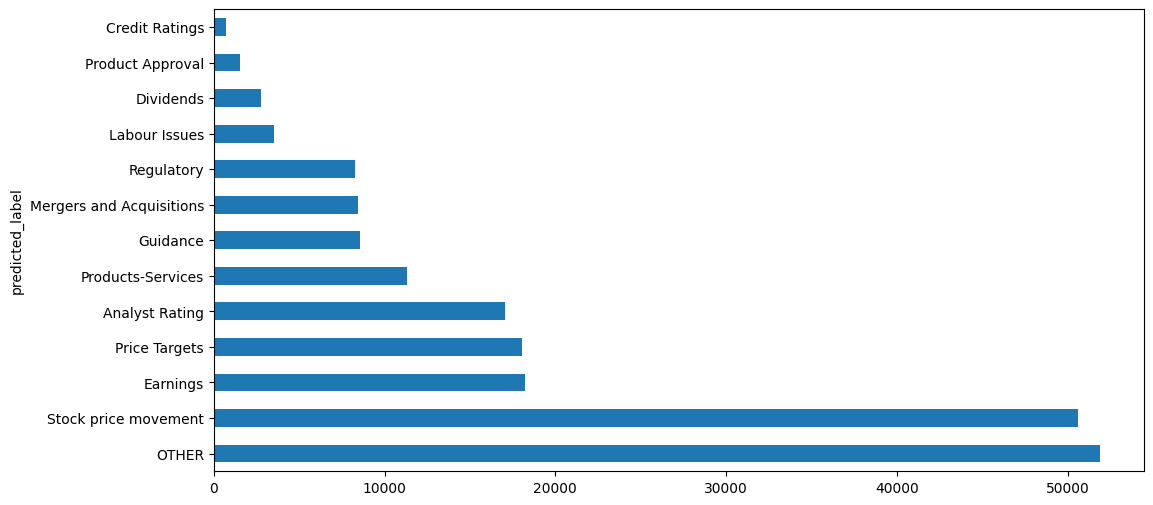

In [23]:
df_clean.groupby('predicted_label').size().sort_values(ascending=False).plot(kind='barh', figsize=(12, 6))

### 1.2.3 Save Results and Cleanup

Save the labeled dataset and delete the model deployment to free up resources.


In [ ]:
labelled_headlines_save_path = project_root / "data"/ "news_data_raw" / "teacher-model-labelled" / "labelled-headlines.csv"
# Create directory if it doesn't exist
labelled_headlines_save_path.parent.mkdir(parents=True, exist_ok=True)
df_clean.to_csv(labelled_headlines_save_path, index=False)

Clean up the teacher model deployment and remove it from the model store:

In [27]:
delete_model_deployment("http://nemo.test", TEACHER_MODEL_NAME, TEACHER_MODEL_NAMESPACE)
delete_model_from_store("http://nemo.test", TEACHER_MODEL_NAME, TEACHER_MODEL_NAMESPACE)

Status: 404
Error: {"message":"model deployment not found","requestId":"f81123051a040b51c531847da56bb0f5"}

Status: 200
Successfully deleted model nvidia/llama-3.3-nemotron-super-49b-v1 from Entity Store


{'message': 'Resource deleted successfully.',
 'id': 'model-61fwkVaFjR5G4L8nNtp6bZ',
 'deleted_at': None}

---

<a id="part2-header"></a>
# Part 2: Data Flywheel Runs

In this part, we will use the labeled data generated in Part 1 to drive the flywheel process. We perform **hard distillation** by fine-tuning smaller student models using LoRA (Low-Rank Adaptation) to match the performance of the larger teacher model, demonstrating how the Data Flywheel enables continuous model improvement with efficient parameter updates.


---

<a id="part2-section0"></a>
## 2.0. Data Flywheel Setup

This step presents two options:
* **Option 1: NVIDIA Brev Launchable Setup:** The instructions below apply **only** to users running this notebook via the Brev Launchable.
  
NVIDIA Brev is a developer-friendly platform that makes it easy to run, train, and deploy ML models on cloud GPUs without the hassle of setup—it comes preloaded with Python, CUDA, and Docker so you can get started fast.

* **Option 2: Self-Hosted Notebook Setup:** The instructions below apply **only** to users running this notebook on their own setup (i.e., if you followed the pre-requisites in the [Data-Flywheel Blueprint Github README](https://github.com/NVIDIA-AI-Blueprints/data-flywheel/tree/main/notebooks#prerequisites) for hardware and software requirements, to clone the repo, and start Jupyter Notebook.)

    > **Note:** If you are using a Brev Launchable, please follow **Option 1** above in this step.

In [48]:
## Important: Uncomment and run this cell in a self-hosted notebook setup

# from pathlib import Path

# notebook_dir = Path.cwd()
# project_root = notebook_dir.parent

## Set up paths and install python dependencies for notebook if running locally. 

# user_site = Path.home() / ".local" / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
# if str(user_site) not in sys.path:
#     sys.path.append(str(user_site))
#     print(f"Added user site-packages to sys.path: {user_site}")

Configure the student models for the Data Flywheel.

In this step, you select which smaller models (student models) will be fine-tuned using the labeled data from Part 1. The code below:
- Defines a list of candidate models (e.g., Llama 3.2 1B, 3B, and 8B variants)
- Specifies customization settings including GPU requirements, context length, and LoRA training parameters
- Updates the `config.yaml` file to configure the flywheel with your selected models

You can customize this by commenting/uncommenting models based on your available resources and requirements. Smaller models (1B, 3B) train faster but may have lower accuracy, while larger models (8B) take longer but can achieve better performance.

In [30]:
import re
from textwrap import dedent

config_path = project_root / "config" / "config.yaml"

new_nims_block = dedent("""\
nims:
  - model_name: "meta/llama-3.2-1b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.2-1b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192

  - model_name: "meta/llama-3.2-3b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.2-3b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192

#  - model_name: "meta/llama-3.1-8b-instruct"
#    model_type: "llm"
#    context_length: 8192
#    pvc_size: 25Gi
#    tag: "1.8.3"
#    gpus: 1
#    customization_enabled: true
#    customizer_configs:
#      target: "meta/llama-3.1-8b-instruct@2.0"
#      gpus: 1
#      max_seq_length: 8192
""")


text = config_path.read_text()

def replace_block(yaml_text: str, key: str, new_block: str) -> str:
    pattern = rf"(?ms)^({re.escape(key)}:[\s\S]*?)(?=^\S|\Z)"
    return re.sub(pattern, new_block, yaml_text)

text = replace_block(text, "nims", new_nims_block)

config_path.write_text(text)
print("config.yaml updated")

config.yaml updated


Start the Data Flywheel service.

This step launches the Data Flywheel infrastructure using Docker Compose, which includes:
- **Data Flywheel service**: Orchestrates the fine-tuning workflow and manages job execution
- **MLflow**: Experiment tracking service for logging metrics, parameters, and model artifacts
- **Weights & Biases (W&B)**: Additional experiment tracking (if `WANDB_API_KEY` is configured in `scripts/deploy-nmp.sh`)
- **Integration with NeMo Microservices**: Connects to the previously deployed NeMo platform for model customization

The command below starts all services in detached mode and logs output to `flywheel_deploy.log`. This typically takes about 10 minutes to fully initialize all containers.

**For manual deployments:** If you deployed NeMo Microservices Platform manually (not via the automated script), update the `nmp_config` field in `config/config.yaml` with your custom base URLs. The default configuration is:
```
nmp_config:
      nemo_base_url: "http://nemo.test"
      nim_base_url: "http://nim.test"
      datastore_base_url: "http://data-store.test"
```

In [31]:
%%bash
echo "Starting data flywheel service..."
export COMPOSE_PROFILES=mlflow && docker compose -f deploy/docker-compose.yaml up -d --build >> flywheel_deploy.log 2>&1
echo "Data flywheel service started successfully!"

Starting data flywheel service...
Data flywheel service started successfully!


---

<a id="part2-section1"></a>
## 2.1. Load Sample Data


First, we need to import required libraries and configure pandas display options for better readability in notebook outputs.

In [32]:
import sys
from pathlib import Path
import requests
import time
from datetime import datetime
import json
import pandas as pd
from IPython.display import display, clear_output
from notebooks.utils.job_monitor_helper import monitor_job

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Width of the display in characters
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

### Overview

In this section, we prepare the labeled data from Part 1 for use in the Data Flywheel. The process involves:

1. **Load labeled data** from Part 1 (teacher model predictions)
2. **Convert to flywheel format** - Transform into prompt-completion pairs with OpenAI ChatCompletions structure
3. **Create stratified subsets** of different sizes (5K, 10K, 25K samples) to demonstrate progressive improvement
4. **Save in JSONL format** and load into Elasticsearch for the flywheel service

Each data point will contain a news headline and its predicted event category from the teacher model, formatted as a training example for student model fine-tuning.

The `request` uses the OpenAI `ChatCompletions` request format and contains the following attributes:

- `model` includes the Model ID used to generate the response.
- `messages` includes a `system` message as well as a `user` query.
- `choices` includes a list of response the llm would've returned

In [ ]:
# Load the dataset using huggingface datasets
import datasets

# Load the dataset from the teacher model labelled data 
# replace the below with dataset 
# ref: labelled_headlines_save_path variable in section 1.2.2
NEWS_DATA_PATH = project_root / 'data' / 'news_data_raw' / 'teacher_model_labelled'
dataset = datasets.load_from_disk(str(NEWS_DATA_PATH))

# Get class labels for stratified sampling
stratify_column_name = "predicted_label"
dataset = dataset.class_encode_column(stratify_column_name)
class_labels = dataset['train'].features['predicted_label']

print(f"Dataset loaded with {len(dataset['train'])} examples")
print(f"Classes: {class_labels.names}")

Casting to class labels: 100%|██████████| 153511/153511 [00:00<00:00, 811485.82 examples/s]

Dataset loaded with 153511 examples
Classes: ['[[analyst rating]]', '[[credit ratings]]', '[[dividends]]', '[[earnings]]', '[[guidance]]', '[[labour issues]]', '[[mergers and acquisitions]]', '[[no event]]', '[[other]]', '[[price targets]]', '[[product approval]]', '[[products-services]]', '[[regulatory]]', '[[stock price movement]]']


Convert the dataset to Data Flywheel format. Each example is transformed into an request/response pair containing:
- **Request**: The classification prompt with the headline
- **Response**: The teacher model's predicted label (ground truth)
- **Metadata**: workload_id, client_id, and timestamp for tracking


In [ ]:
TEACHER_MODEL = "meta/llama-3.3-70b-instruct"

def convert_to_flywheel_format(dataset_split, workload_id, client_id):
    """
    Convert news classification dataset to flywheel log format
    """
    flywheel_data = []
    
    for idx, example in enumerate(dataset_split):
        headline = example["headline"]
        label = class_labels.int2str(example["predicted_label"])
        
        # Create request in chat completion format
        request = {
            "model": TEACHER_MODEL,  # Base model used for ground truth
            "messages": [
                {
                    "role": "system",
                    "content": "You are a financial news classifier."
                },
                {
                    "role": "user",
                    "content": PROMPT.format(headline=headline)
                }
            ]
        }
        
        # Create response with ground truth completion
        response = {
            "choices": [
                {
                    "message": {
                        "role": "assistant",
                        "content": f"{label}"
                    }
                }
            ]
        }
        
        # Create flywheel log entry
        log_entry = {
            "request": request,
            "response": response,
            "workload_id": workload_id,
            "client_id": client_id,
            "timestamp": int(time.time()) + idx
        }
        
        flywheel_data.append(log_entry)
    
    return flywheel_data

Create stratified subsets of different sizes (5K, 10K, 25K samples) to demonstrate how model performance improves with more training data:


In [37]:
dataset = dataset.get('train')
print("Dataset splits created:")
print(f"  Train: {len(dataset)} examples")

# Specify the number of samples to pick from trainset
SAMPLE_SIZES = [5000, 10000, 25000]

def create_stratified_subset(dataset, n_samples, random_state=42):
    """Create a stratified subset maintaining class distribution."""
    if n_samples >= len(dataset):
        return dataset
    train_size = n_samples / len(dataset)
    return dataset.train_test_split(
        train_size=train_size, seed=random_state, stratify_by_column='predicted_label'
    )['train']

# Create stratified subsets
client_datasets = {
    f"news-classifier-{size}": create_stratified_subset(dataset, size)
    for size in SAMPLE_SIZES
}

print("Client datasets created:")
for name, ds in client_datasets.items():
    print(f"  {name}: {len(ds)} examples")


Dataset splits created:
  Train: 153511 examples


Client datasets created:
  news-classifier-5000: 5000 examples
  news-classifier-10000: 10000 examples
  news-classifier-25000: 25000 examples


In [ ]:
# Save datasets in flywheel format
FLYWHEEL_DATA_DIR = data_dir / "news_classification"
FLYWHEEL_DATA_DIR.mkdir(exist_ok=True)

In [40]:
for client_id, ds in client_datasets.items():
    flywheel_data = convert_to_flywheel_format(
        ds, 
        workload_id="news_classifier",
        client_id=client_id
    )
    
    output_file = FLYWHEEL_DATA_DIR / f"{client_id}_dataset.jsonl"
    with open(output_file, 'w') as f:
        for entry in flywheel_data:
            f.write(json.dumps(entry) + '\n')
    
    print(f"Saved {len(flywheel_data)} examples to {output_file}")

Saved 5000 examples to /home/shadeform/ai-model-distillation-for-financial-data/data/news_classification/news-classifier-5000_dataset.jsonl
Saved 10000 examples to /home/shadeform/ai-model-distillation-for-financial-data/data/news_classification/news-classifier-10000_dataset.jsonl
Saved 25000 examples to /home/shadeform/ai-model-distillation-for-financial-data/data/news_classification/news-classifier-25000_dataset.jsonl


The data points generated by the teacher model are considered **ground truth**. 

Ground truth data points are used to **evaluate** and **customize** more efficient models that can perform similarly to the teacher model. This customization process is analogous to a student-teacher distillation setup, where synthetic data generated from the teacher model is used to fine-tune a student model.

Next, we'll load the data into Elasticsearch using a helper method `load_data_to_elasticsearch`, making it accessible to the Data Flywheel service.

Load the prepared datasets into Elasticsearch, making them accessible to the Data Flywheel service for training:

> **Note:** We start with the 5K sample dataset. You can uncomment the larger datasets (10K, 25K) later to demonstrate progressive improvement.


In [41]:
from src.scripts.load_test_data import load_data_to_elasticsearch

DATA_FILES = [
    "news-classifier-5000_dataset.jsonl",
    # "news-classifier-10000_dataset.jsonl",
    # "news-classifier-25000_dataset.jsonl",
]

for file in DATA_FILES:
    DATA_PATH = FLYWHEEL_DATA_DIR / file
    load_data_to_elasticsearch(file_path=DATA_PATH)

Elasticsearch is ready! Status: green
Elasticsearch is ready! Status: green
Creating primary index: flywheel...
Creating primary index: flywheel...
Document is already in the log format. Loading with overrides.
Data loaded successfully.


---

<a id="part2-section2"></a>
## 2.2. Create a Flywheel Job

Initiate a Flywheel job by sending a POST request to the `/jobs` API. This triggers the workflow asynchronously.

In production environments, you can automate this process to run at scheduled intervals, in response to specific events, or on demand.

For this tutorial, we will target the news classification workload by setting the `workload_id` to "news_classifier" and we will set `client_id` to "news-classifier-5000" which has 5000 data points.

In [42]:
API_BASE_URL = "http://localhost:8000"

In [43]:
response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "news_classifier", "client_id": "news-classifier-5000"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 691efe77eb35c9c91df67b19


For each candidate model, the data flywheel performs customization (fine-tuning) and evaluates the customized model using the F1 score metric to measure how well the student model matches the teacher model's performance.

---

<a id="part2-section3"></a>
## 2.3. Monitor Job Status

Once a job is submitted, you can check its status at any time using a simple API call:

In [44]:
def get_job_status(job_id):
    """Get the current status of a job."""
    response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")
    response.raise_for_status()
    return response.json()

In [45]:
get_job_status(job_id)

{'id': '691efe77eb35c9c91df67b19',
 'workload_id': 'news_classifier',
 'client_id': 'news-classifier-5000',
 'status': 'running',
 'started_at': '2025-11-20T11:41:43.806000',
 'finished_at': None,
 'num_records': 5000,
 'llm_judge': None,
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 10.109086,
   'evaluations': [],
   'customizations': [],
   'error': None},
  {'model_name': 'meta/llama-3.2-3b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 0.0,
   'evaluations': [],
   'customizations': [],
   'error': None}],
 'datasets': [{'name': 'flywheel-eval-news_classifier-1763638905',
   'num_records': 100,
   'nmp_uri': 'hf://datasets/dfwbp/flywheel-eval-news_classifier-1763638905'},
  {'name': 'flywheel-train-news_classifier-1763638905',
   'num_records': 4410,
   'nmp_uri': 'hf://datasets/dfwbp/flywheel-train-news_classifier-1763638905'}],
 'error': None}

The status output shows the job's progress, including which models are being trained, their deployment status, and any completed evaluations or customizations.


### Continuous Monitoring

Rather than manually checking job status repeatedly, we provide a `monitor_job` utility function that automatically tracks the entire flywheel workflow:

- **Polls job status** at regular intervals until completion
- **Displays progress** in a formatted table showing customization and evaluation status for each model
- **Logs metrics to MLflow** when evaluations complete, enabling performance comparison across models and runs
- **Logs to Weights & Biases (W&B)** if `WANDB_API_KEY` is configured in `scripts/deploy-nmp.sh` - metrics and visualizations will populate to your W&B dashboard

This automated monitoring is especially useful since fine-tuning jobs typically take 50+ minutes to complete. 

### (Optional) Viewing Experiment Dashboards

**MLflow Dashboard:**

The MLflow dashboard provides interactive visualizations of your experiments, including charts comparing F1 scores, accuracy, and training metrics across different models and runs. It also logs model artifacts and hyperparameters for reproducibility. 

If MLflow visualization is enabled, the MLflow dashboard will be available at port 5000 (default)

**Accessing MLflow:**
* **If using Brev Launchable:**
    Navigate to your Brev instance page, go to the `Access` tab, select `Using Secure Links`, and click the link that looks like `https://mlflow-*.brevlab.com`. As evaluation jobs complete, they will be logged in MLflow with their flywheel `job_id` as the MLflow experiment name.
* **If using a Self-Hosted Notebook Setup:**
    Open your browser and go to `<local-IP>:5000`

**Weights & Biases (W&B) Dashboard:**

If you configured `WANDB_API_KEY` in `scripts/deploy-nmp.sh`, all training metrics, evaluation results, and model artifacts will automatically sync to your Weights & Biases project. Visit [wandb.ai](https://wandb.ai) to view comprehensive experiment tracking, model comparisons, and performance visualizations.

Start monitoring the job. The output will show a live-updating table displaying:
- **Customization progress** for each model (training status and runtime)
- **Evaluation results** comparing base model (before fine-tuning) vs. customized model (after LoRA fine-tuning) F1 scores
- **Links to MLflow** for detailed metrics visualization
- **W&B experiment tracking** (if `WANDB_API_KEY` is configured) with real-time training curves and model comparisons

> **Note:** The first customization run typically takes about **10 minutes** to start while the training container is being downloaded. The `monitor_job` call in the cell below usually requires around **50 minutes** to complete training and evaluation of the candidate NIMs, though the exact duration may vary depending on the specific GPU and the responsiveness of the remote endpoint used for LLM-judge evaluations.  
>  
> As the evaluations complete, you will begin to see metrics appear in the monitoring table, MLflow dashboard, and W&B dashboard (if configured).

Job Status: completed
Total Records: 5000
Last Updated: 12:16:31

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,F1 Score
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,11s,Completed,11:47:16,11:47:26,0.362
1,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,11s,Completed,12:02:49,12:03:00,0.610
2,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,15s,Completed,12:07:37,12:07:52,0.590
3,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,16s,Completed,12:15:10,12:15:25,0.850



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
0,meta/llama-3.2-1b-instruct,11:47:16,1,70,12:02:49,Completed,15m 33s,100.0
1,meta/llama-3.2-3b-instruct,12:07:37,1,70,12:15:10,Completed,7m 32s,100.0


{'id': '691efe77eb35c9c91df67b19',
 'workload_id': 'news_classifier',
 'client_id': 'news-classifier-5000',
 'status': 'completed',
 'started_at': '2025-11-20T11:41:43.806000',
 'finished_at': '2025-11-20T12:16:26.532000',
 'num_records': 5000,
 'llm_judge': None,
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 1271.496311,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'f1_score': 0.36199999999999993},
     'started_at': '2025-11-20T11:47:16.332000',
     'finished_at': '2025-11-20T11:47:26.560000',
     'runtime_seconds': 11.799093,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-MgYEs7yF4fRZNR1jaf8v72',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/871530244188056832',
     'error': None},
    {'eval_type': 'customized-eval',
     'scores': {'f1_score': 0.61},
     'started_at': '2025-11-20T12:02:49.981000',
     'finished_at': '2025-11

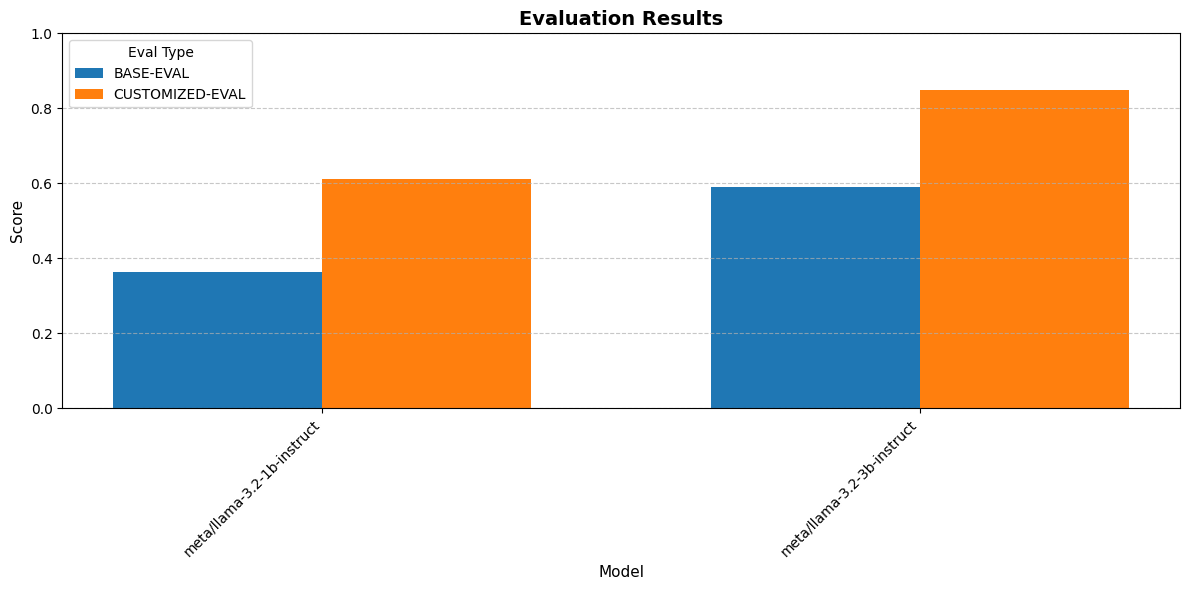

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [46]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id = job_id,
    poll_interval=10
) 

Job Status: completed
Total Records: 5000
Last Updated: 12:16:41

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,F1 Score
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,11s,Completed,11:47:16,11:47:26,0.362
1,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,11s,Completed,12:02:49,12:03:00,0.610
2,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,15s,Completed,12:07:37,12:07:52,0.590
3,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,16s,Completed,12:15:10,12:15:25,0.850



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
0,meta/llama-3.2-1b-instruct,11:47:16,1,70,12:02:49,Completed,15m 33s,100.0
1,meta/llama-3.2-3b-instruct,12:07:37,1,70,12:15:10,Completed,7m 32s,100.0


{'id': '691efe77eb35c9c91df67b19',
 'workload_id': 'news_classifier',
 'client_id': 'news-classifier-5000',
 'status': 'completed',
 'started_at': '2025-11-20T11:41:43.806000',
 'finished_at': '2025-11-20T12:16:26.532000',
 'num_records': 5000,
 'llm_judge': None,
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 1271.496311,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'f1_score': 0.36199999999999993},
     'started_at': '2025-11-20T11:47:16.332000',
     'finished_at': '2025-11-20T11:47:26.560000',
     'runtime_seconds': 11.799093,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-MgYEs7yF4fRZNR1jaf8v72',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/871530244188056832',
     'error': None},
    {'eval_type': 'customized-eval',
     'scores': {'f1_score': 0.61},
     'started_at': '2025-11-20T12:02:49.981000',
     'finished_at': '2025-11

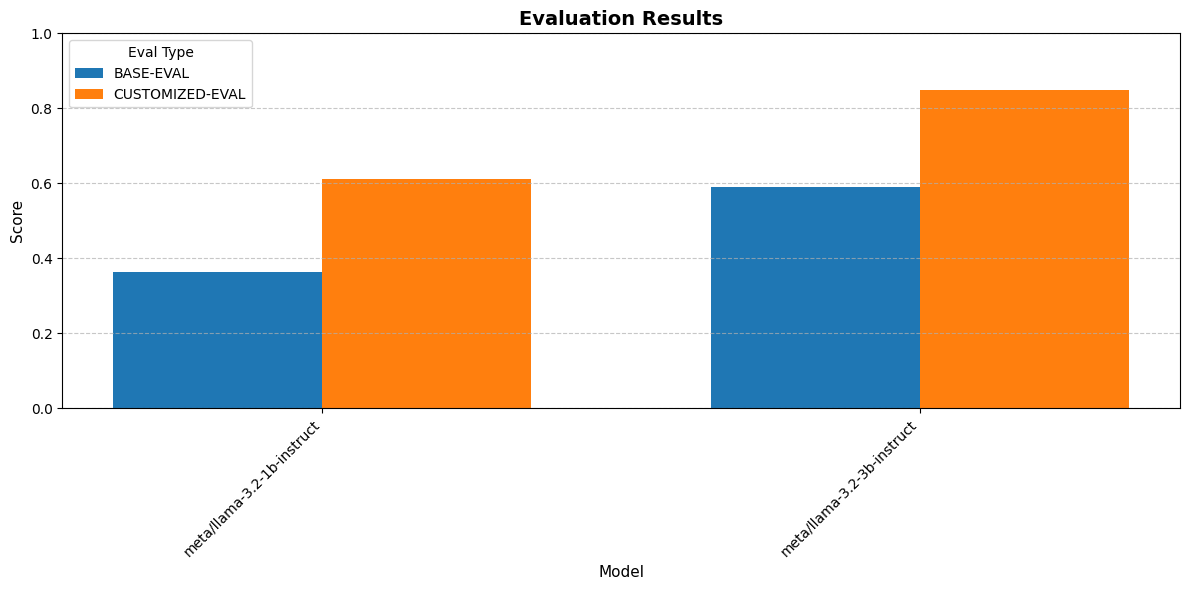

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [47]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id = job_id,
    poll_interval=10
) 

### Results Summary

Congratulations! You've successfully completed a Data Flywheel run. You can now:
- **Review metrics** in the monitoring table, MLflow dashboard, and W&B dashboard (if configured) to compare model performance
- **Decide which model to promote** based on accuracy vs. resource trade-offs (1B models are fastest but may have lower F1 scores than 3B/8B models)
- **Note:** With only 5000 training examples, the customized models may still have limited accuracy

The Data Flywheel operates as a **self-reinforcing cycle**—models continue to improve as you supply additional training data. In the next sections, we demonstrate how model accuracy improves incrementally with larger datasets (10K, 25K samples).

---

<a id="part2-section4"></a>
## 2.4. Show Continuous Improvement (Optional)

To demonstrate how the Data Flywheel enables continuous improvement, we'll run additional jobs with increasing amounts of training data.

### 2.4.1. Run with 10K samples

To extend the flywheel run with additional data, we'll launch a new job using `client_id` set to "news-classifier-10000", which includes **10000** data points, to evaluate the impact of increased data volume on performance.

Note that `client_id` is originally intended to identify the client that generated the traffic. However, in the notebook, it was repurposed to represent datasets of varying sizes, illustrating the progressive improvement of the data flywheel as more data is collected.

In [34]:
API_BASE_URL = "http://localhost:8000"

response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "news_classifier", "client_id": "news-classifier-10000"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 6908e32bbc6278d862914372


Monitor this job to see how performance improves with the larger 10K dataset. The output table will show evaluation results comparing base model vs. customized model F1 scores for each student model:


Job Status: completed
Total Records: 10000
Last Updated: 18:29:01

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,F1 Score
4,meta/llama-3.1-8b-instruct,BASE-EVAL,100.0,20s,Completed,17:58:48,17:59:08,0.74
5,meta/llama-3.1-8b-instruct,CUSTOMIZED-EVAL,100.0,25s,Completed,18:27:22,18:27:48,0.94
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,10s,Completed,17:18:02,17:18:12,0.34
1,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,10s,Completed,17:30:34,17:30:44,0.78
2,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,15s,Completed,17:35:01,17:35:16,0.67
3,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,20s,Completed,17:53:04,17:53:24,0.89



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
2,meta/llama-3.1-8b-instruct,17:58:48,1,72,18:27:22,Completed,28m 34s,100.0
0,meta/llama-3.2-1b-instruct,17:18:02,1,71,17:30:34,Completed,12m 32s,100.0
1,meta/llama-3.2-3b-instruct,17:35:01,1,72,17:53:04,Completed,18m 2s,100.0


{'id': '6908e32bbc6278d862914372',
 'workload_id': 'news_classifier',
 'client_id': 'news-classifier-10000',
 'status': 'completed',
 'started_at': '2025-11-03T17:15:23.127000',
 'finished_at': '2025-11-03T18:28:48.618000',
 'num_records': 10000,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 918.131595,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'f1_score': 0.34},
     'started_at': '2025-11-03T17:18:02.751000',
     'finished_at': '2025-11-03T17:18:12.819000',
     'runtime_seconds': 10.796267,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-WFtSB5Wbh6vRBK5icnDGKZ',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/269446189192121062',
     'error': None},
    {'eval_type': 'customized-eval',
     'scores': {

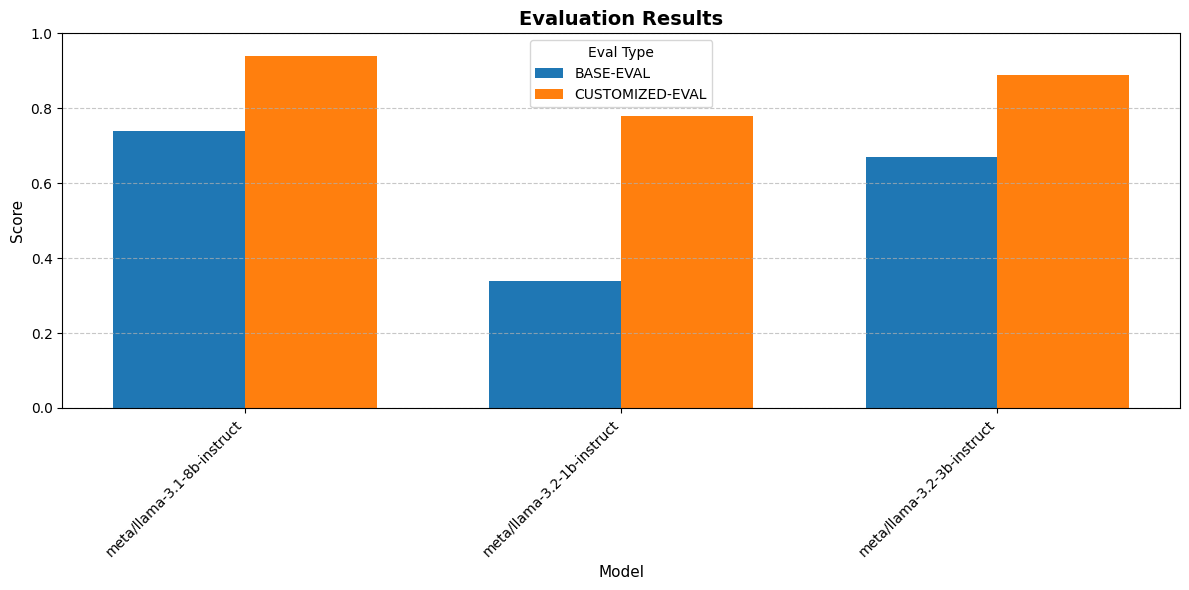

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [35]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=15
)

---

### 2.4.2. Run with 25K samples

Finally, to extend the flywheel run with additional data, we'll launch yet another job using `client_id` set to "news-classifier-25000", which includes **25000** data points, to evaluate the impact of increased data volume on performance. 

At some point we will reach an upper threshold on whether the student model can mimic the performance of the teacher model or not. In this case we rely on the F1-score. If we achieve an F1-score of 1.0 or 100%, we can claim that the student model is as good as the teacher model for this specific task.

Note that `client_id` is originally intended to identify the client that generated the traffic. However, in the notebook, it was repurposed to represent datasets of varying sizes, illustrating the progressive improvement of the data flywheel as more data is collected.

In [29]:
API_BASE_URL = "http://localhost:8000"

response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={"workload_id": "news_classifier", "client_id": "news-classifier-25000"}
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 690551bdc19adaa12f4aefea


Monitor the 25K dataset job to observe the final performance gains. With this larger dataset, you should see F1 scores approaching or potentially matching the teacher model's performance:


Job Status: running
Total Records: 25000
Last Updated: 02:37:39

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,F1 Score
4,meta/llama-3.1-8b-instruct,BASE-EVAL,100.0,20s,Completed,01:32:11,01:32:31,0.720000
5,meta/llama-3.1-8b-instruct,CUSTOMIZED-EVAL,100.0,25s,Completed,02:36:53,02:37:18,0.950000
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,10s,Completed,00:21:08,00:21:18,0.316667
1,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,10s,Completed,00:45:13,00:45:23,0.900000
2,meta/llama-3.2-3b-instruct,BASE-EVAL,100.0,15s,Completed,00:48:49,00:49:04,0.634000
3,meta/llama-3.2-3b-instruct,CUSTOMIZED-EVAL,100.0,20s,Completed,01:27:57,01:28:17,0.950000



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
2,meta/llama-3.1-8b-instruct,01:32:11,1,179,02:36:53,Completed,64m 41s,100.0
0,meta/llama-3.2-1b-instruct,00:21:08,1,179,00:45:13,Completed,24m 4s,100.0
1,meta/llama-3.2-3b-instruct,00:48:49,1,179,01:27:57,Completed,39m 7s,100.0


{'id': '690551bdc19adaa12f4aefea',
 'workload_id': 'news_classifier',
 'client_id': 'news-classifier-25000',
 'status': 'running',
 'started_at': '2025-11-01T00:18:05.493000',
 'finished_at': None,
 'num_records': 25000,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 1620.218074,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'f1_score': 0.31666666666666665},
     'started_at': '2025-11-01T00:21:08.875000',
     'finished_at': '2025-11-01T00:21:18.956000',
     'runtime_seconds': 10.080636,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-7QT6emoXBi59zaCy8i5CcZ',
     'mlflow_uri': None,
     'error': None},
    {'eval_type': 'customized-eval',
     'scores': {'f1_score': 0.9},
     'started_at': '2025-11-01T00:45:13.58

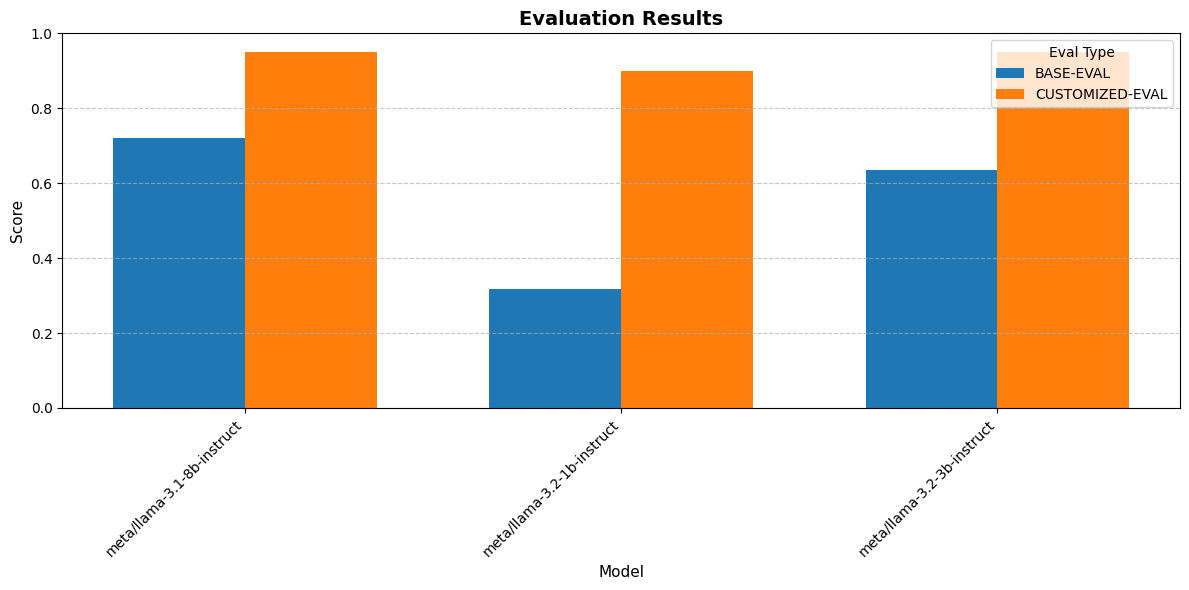

<Figure size 640x480 with 0 Axes>


Monitoring stopped by user


In [33]:
monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=15
)

---

<a id="part2-section5"></a>
## 2.5. Deploy Customized Model and Run Inference

NeMo Microsevices Platform provides two component microservices to simplify model deployment and inference:

- NeMo Deployment Management: Provides an API to deploy NIM on a Kubernetes cluster and manage them through the NIM Operator microservice.
- NeMo NIM Proxy: Provides a unified endpoint that you can use to access all deployed NIM for inference tasks.

First, we will list all the models which are available. Next, we need to get the name of the fine-tuned model, which can be obtained from the job status API.

The customized model, deployed as a NIM, will automatically pick up the LoRA adaptor.

In [60]:
from src.scripts.nim_helpers import create_model_deployment, delete_model_deployment

In [36]:
payload = {
    "name": "llama-3.2-3b-instruct",
    "namespace": "meta",
    "config": {
        "model": "meta/llama-3.2-3b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.2-3b-instruct",
            "image_tag": "1.8",
            "pvc_size": "25Gi",
            "gpu": 1,
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines"
            }
        }
    }
}

nim_deployment = create_model_deployment(
    ENTITY_STORE_URL="http://nemo.test",
    name="llama-3.2-3b-instruct",
    namespace="meta",
    payload=payload
)
print(nim_deployment)

Successfully created deployment llama-3.2-3b-instruct in namespace meta
{'async_enabled': False, 'config': {'model': 'meta/llama-3.2-3b-instruct', 'nim_deployment': {'additional_envs': {'NIM_GUIDED_DECODING_BACKEND': 'outlines'}, 'disable_lora_support': False, 'gpu': 1, 'image_name': 'nvcr.io/nim/meta/llama-3.2-3b-instruct', 'image_tag': '1.8', 'pvc_size': '25Gi'}}, 'created_at': '2025-11-01T02:38:33.429760408Z', 'deployed': False, 'name': 'llama-3.2-3b-instruct', 'namespace': 'meta', 'status_details': {'description': 'Model deployment created', 'status': 'pending'}, 'url': ''}


Now we can run inference with the fine-tuned model using the NIM Proxy service:
Note: Wait until the deployment is finished, it may take ~5 mins.

In [43]:
response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")  # use the job_id for the best run based on eval results
target_model_name = 'meta/llama-3.2-3b-instruct'
for nims in response.json()['nims']:
    if nims['model_name'] == target_model_name:
        ft_model_name = nims['customizations'][0]['customized_model']
        break
print("Customized Model: ", ft_model_name)

Customized Model:  dfwbp/customized-meta-llama-3.2-3b-instruct@cust-6vxSUPYMgpPf4zvkgiTxeW


In [ ]:
path_manually_labelled = project_root / "data" / "news_data_raw" / "manually_labelled"
manually_labelled_data = datasets.load_dataset(str(path_manually_labelled))
df_manually_labelled = manually_labelled_data['train'].to_pandas()
df_manually_labelled['label'] = df_manually_labelled['label'].apply(lambda x: x.lower())

In [56]:
import asyncio
import aiohttp

async def classify_headline(session, headline, model_name):
    """Get classification for a single headline."""
    # Use the PROMPT from the notebook, formatted with the headline
    prompt = DATASET_PROMPT_FORMAT.format(headline=headline)
    payload = {
        "model": model_name,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 100,
        "temperature": 0.4
    }
    
    async with session.post("http://nim.test/v1/chat/completions", json=payload) as response:
        result = await response.json()
        return result['choices'][0]['message']['content']

async def process_dataset(dataset, model_name, num_samples=None, concurrent=10):
    """Process headlines and return DataFrame with headline and predicted_label."""
    # Access headlines directly from the dataset column
    if num_samples is None:
        headlines = dataset['train']['headline']
    else:
        headlines = dataset['train']['headline'][:num_samples]
    
    semaphore = asyncio.Semaphore(concurrent)
    
    async def classify_with_limit(session, headline):
        async with semaphore:
            label = await classify_headline(session, headline, model_name)
            return {"headline": headline, "predicted_label": label}
    
    async with aiohttp.ClientSession() as session:
        tasks = [classify_with_limit(session, h) for h in headlines]
        results = await asyncio.gather(*tasks)
    
    return pd.DataFrame(results)

In [ ]:
df_sanity_check = await process_dataset(manually_labelled_data,ft_model_name, concurrent=200)
df_sanity_check['predicted_label'] = df_sanity_check['predicted_label'].apply(lambda x: x.strip('[]')).apply(lambda x: x.lower())
df_sanity_check.head()

Generate a classification report that shows precision, recall, and F1-score for each event category, providing a detailed breakdown of how well the fine-tuned model performs on manually labeled test data:


In [ ]:
from sklearn.metrics import classification_report


print(classification_report(df_manually_labelled['label'], df_sanity_check['predicted_label']))

                          precision    recall  f1-score   support

          analyst rating       0.81      0.98      0.89        96
          credit ratings       0.97      0.97      0.97        61
               dividends       1.00      1.00      1.00        71
                earnings       0.94      0.89      0.92        75
                guidance       0.93      0.94      0.93        83
           labour issues       0.78      0.86      0.82        88
      management changes       0.00      0.00      0.00        22
mergers and acquisitions       0.96      0.77      0.86        88
                no event       0.00      0.00      0.00         0
                   other       0.60      0.46      0.52        93
           price targets       0.99      1.00      0.99        66
        product approval       0.97      0.88      0.92        72
       products-services       0.77      0.88      0.82        49
              regulatory       0.78      0.75      0.77        85
    stock

/home/shadeform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shadeform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shadeform/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/shadef

In [ ]:
delete_model_deployment(
    ENTITY_STORE_URL="http://nemo.test",
    name="llama-3.2-3b-instruct",
    namespace="meta"
)

Status: 200
Successfully deleted deployment meta/llama-3.2-3b-instruct


{'deleted_at': '2025-11-01 02:53:48.849735826 +0000 UTC m=+33053.358725104',
 'id': 'llama-3.2-3b-instruct',
 'message': 'Resource deleted successfully'}

Optionally, you can also download the LoRA adapters. In Nemo Microservices Platform, LoRA adapters are uploaded to NeMo Data Store after fine tuning. NeMo Data Store exposing APIs compatible with the Hugging Face Hub client which we can interact with to download the LoRA adapters.

In [32]:
from huggingface_hub import snapshot_download

DATA_STORE_ENDPOINT = "http://data-store.test"  # if you used Launchable setup, then the base url to NeMo Data Store will be http://data-store.test. Otherwise, change the base url accordingly.
MODEL_ID, CUSTOMIZATION_JOB_ID = ft_model_name.split('@', 1)

# Download the model
local_model_path = snapshot_download(
    repo_id=MODEL_ID,
    repo_type="model",
    revision=CUSTOMIZATION_JOB_ID,
    local_dir="./downloaded_loras",
    endpoint=f"{DATA_STORE_ENDPOINT}/v1/hf",
    force_download=True
)

print(f"Model downloaded to: {local_model_path}")

Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 59.09it/s]

Model downloaded to: /home/ubuntu/data-flywheel/downloaded_loras


---

<a id="part2-section6"></a>
## 2.6. Expose the Customized Model for External Access (Brev Launchable Only)

To enable external access to the customized model, we first need to do local port forwarding:

In [ ]:
import subprocess

# Forward local port 8080 to service port 8000
log_file = open("port_forward.log", "w")
pf_process = subprocess.Popen(
    ["kubectl", "port-forward", "svc/nemo-nim-proxy", "8080:8000"],
    stdout=log_file,
    stderr=log_file,
)

print(f"Port-forward started in background with PID {pf_process.pid}")

Port-forward started in background with PID 3835160


Next navigate to your Brev instance page, go to the `Access` tab, select `Using Secure Links`, find the link that looks like https://inference-*.brevlab.com, click the `Edit Access`, and toggle on `Make Public`.

Now you should be able to run inference with the above url externally:

In [ ]:
url = "https://inference-16qlcb1wy.brevlab.com/v1/chat/completions"  # if you used Launchable setup, update the url according to the url from Brev instance page.

headers = {
    "Content-Type": "application/json"
}
payload = {
    "model": ft_model_name,
    "messages": input_data['request']['messages'],
    "tools": input_data['request']['tools'],
    "stream": False
}

response = requests.post(url, headers=headers, json=payload)
response.json()['choices'][0]['message']

{'role': 'assistant',
 'content': None,
 'tool_calls': [{'id': 'chatcmpl-tool-e8c71f8d75634481af6ee72596f82e1e',
   'type': 'function',
   'function': {'name': 'ToProductQAAssistant',
    'arguments': '{"query": "what colors are available for the Geforce Hat?"}'}}]}

---

## Conclusion


You've successfully completed the AI Model Distillation for Financial Data workflow! In this notebook, you:

1. **Generated high-quality labels** using a large teacher model (Llama 3.3 70B Instruct or Llama 3.3 Nemotron Super 49B)
2. **Performed hard distillation** by fine-tuning smaller student models using LoRA on the labeled data
3. **Demonstrated continuous improvement** through the Data Flywheel with increasing dataset sizes
4. **Deployed and validated** the customized models for production use

The distilled models achieve teacher-level performance while being significantly smaller and more efficient, making them ideal for production deployments where latency and cost matter.

**Next Steps:**
- Fine-tune with even larger datasets to further improve accuracy
- Experiment with different student models or LoRA configurations
- Deploy your customized models to production inference endpoints
- Integrate the Data Flywheel into your MLOps pipeline for continuous model improvement

For more information, visit the [NVIDIA AI Blueprints](https://docs.nvidia.com/ai-enterprise/ai-blueprints/) documentation.
